---
title: "Geo-Spatial Analysis"
author: Daniel Redel
date: today
format:
  html:
    toc: true
    code-fold: true
    html-math-method: katex
jupyter: python3
---

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore')

my_colors =['#28AFB0', '#F46036', '#F1E3D3', '#2D1E2F', '#26547C', '#28AFB0']
file = "D:/Career/Data Science/Portfolios/Inside AirBnB - Netherlands/Amsterdam/"

listings = pd.read_csv("listings_processed.csv") # processed data
#calendar = pd.read_csv('calendar_processed.csv') # processed data
#neighbourhoods = pd.read_csv(file + 'neighbourhoods.csv')

# Maps in `geopandas`

**GeoPandas** allow to work with geospatial data in python in an easy way. GeoPandas extends the datatypes used by pandas to allow spatial operations on geometric types.

In [2]:
#| label: tbl-raw-dataset
#| tbl-cap: Listings Dataset

listings = listings[['id', 'neighbourhood', 'latitude', 'longitude', 'room_type', 'price', 'number_of_reviews']]
listings.head(2)

,id,neighbourhood,latitude,longitude,room_type,price,number_of_reviews
0,2818,Oostelijk Havengebied - Indische Buurt,52.36435,4.94358,Private room,69,322
1,20168,Centrum-Oost,52.36407,4.89393,Private room,106,339


The core data structure in GeoPandas is the `geopandas.GeoDataFrame`, a subclass of `pandas.DataFrame`, that _can store geometry columns_ and perform spatial operations. Let's convert our dataset into a GeoDataFrame:

In [3]:
#| code-fold: false

gdf = gpd.GeoDataFrame(listings, 
                             geometry=gpd.points_from_xy(listings.longitude, listings.latitude), crs="EPSG:4326"
)

We can now plot our ``GeoDataFrame``

## Room Type

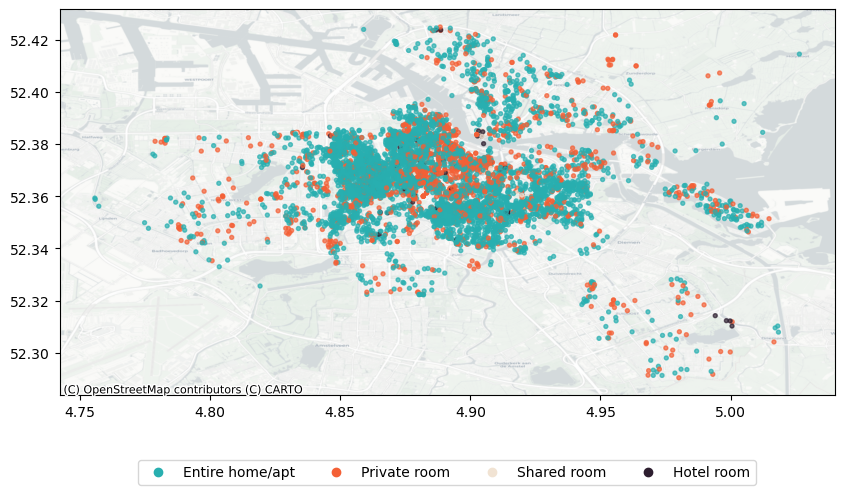

In [7]:
#| label: fig-room
#| fig-cap: Listings by Room Type

import contextily as ctx

my_colors =['#28AFB0', '#F46036', '#F1E3D3', '#2D1E2F', '#26547C']

custom_palette = {
    'Entire home/apt': my_colors[0],
    'Private room': my_colors[1],
    'Shared room': my_colors[2],
    'Hotel room': my_colors[3]
}

# Map column values to colors based on your custom palette
colors = gdf['room_type'].map(custom_palette)

# Plot
ax = gdf.plot(column='room_type', alpha=0.7, color=colors, legend=True, figsize=(10, 10), markersize=8)
# Add basemap from OpenStreetMap
ctx.add_basemap(ax, crs=gdf.crs.to_string(), zoom=13, source=ctx.providers.CartoDB.Positron)


# Create a custom legend
legend_elements = [plt.Line2D([0], [0], marker='o', color=color, label=label, linestyle='None') 
                   for label, color in custom_palette.items()]

# Place legend outside the plot area
plt.legend(handles=legend_elements, loc='center', bbox_to_anchor=(0.5, -0.2), ncol=len(custom_palette))


plt.show()

It's clear from @fig-room that most of the units are either entire homes or private rooms, whose spatial distribution is more or less similar similar. Let's focus now only on the remaining units (shared, hotels):

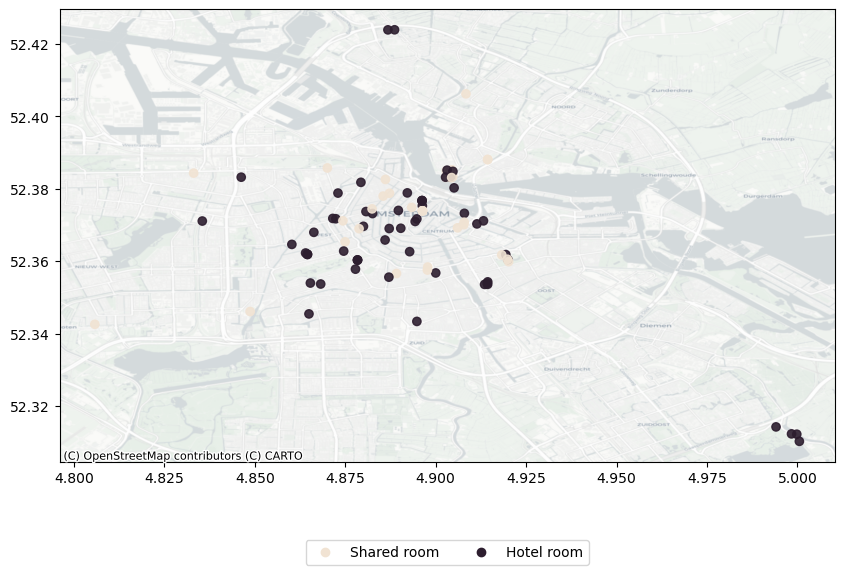

In [24]:
#| label: fig-room-filtered
#| fig-cap: Listings by Room Type (Filtered)

import contextily as ctx

my_colors =['#28AFB0', '#F46036', '#F1E3D3', '#2D1E2F', '#26547C']
room_filter = gdf['room_type'].isin(['Shared room', 'Hotel room'])

custom_palette = {
    'Shared room': my_colors[2],
    'Hotel room': my_colors[3]
}

# Map column values to colors based on your custom palette
colors = gdf[room_filter]['room_type'].map(custom_palette)

# Plot
ax = gdf[room_filter].plot(column='room_type', alpha=0.9, color=colors, legend=True, figsize=(10, 10))
# Add basemap from OpenStreetMap
ctx.add_basemap(ax, crs=gdf.crs.to_string(), zoom=13, source=ctx.providers.CartoDB.Positron)


# Create a custom legend
legend_elements = [plt.Line2D([0], [0], marker='o', color=color, label=label, linestyle='None') 
                   for label, color in custom_palette.items()]

# Place legend outside the plot area
plt.legend(handles=legend_elements, loc='center', bbox_to_anchor=(0.5, -0.2), ncol=len(custom_palette))


plt.show()

## Price

One way to study price patterns with maps is to just plotting the location of each units by price gradient:

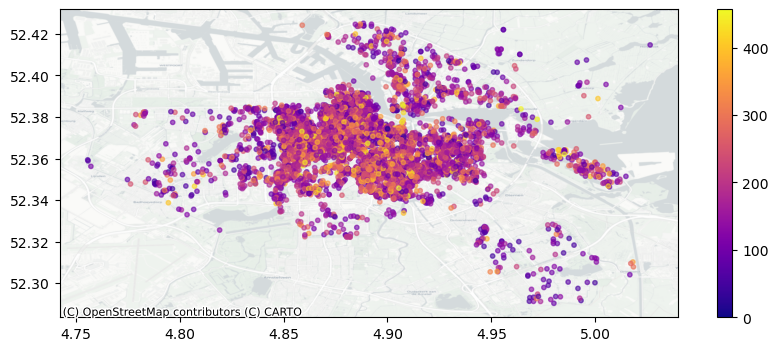

In [26]:
#| label: fig-price
#| fig-cap: Listings by Price

import contextily as ctx

# Plot
ax = gdf.plot(column='price', cmap='plasma', alpha=0.6, legend=True, figsize=(10, 4), markersize=10)

# OpenStreetMap
ctx.add_basemap(ax, crs=gdf.crs.to_string(), zoom=13, source=ctx.providers.CartoDB.Positron)

plt.show()

@fig-price visualizes the spatial distribution of Airbnb listings in Amsterdam, with each unit plotted according to a gradient of prices. Darker shades represent higher-priced listings, while lighter shades indicate lower-priced ones. 

The initial map encountered a challenge due to the high density of listings, resulting in significant overlap that obscured meaningful patterns. This overlap made it difficult to discern spatial trends and understand price variations. 

To address this issue, we opted for a choropleth map illustrating the average price by neighborhood:

In [10]:
#| code-fold: false

import pandas as pd

# Read the GeoJSON file
amsterdam_geojson_file = "neighbourhoods.geojson"  # Replace with the path to your GeoJSON file
amsterdam_gdf = gpd.read_file(amsterdam_geojson_file)

# Group by Neighbourhood
df_mean_p = pd.DataFrame(gdf.groupby('neighbourhood')['price'].agg('mean')).reset_index()
gdf_neigh = pd.merge(amsterdam_gdf, df_mean_p, on='neighbourhood', how='inner')


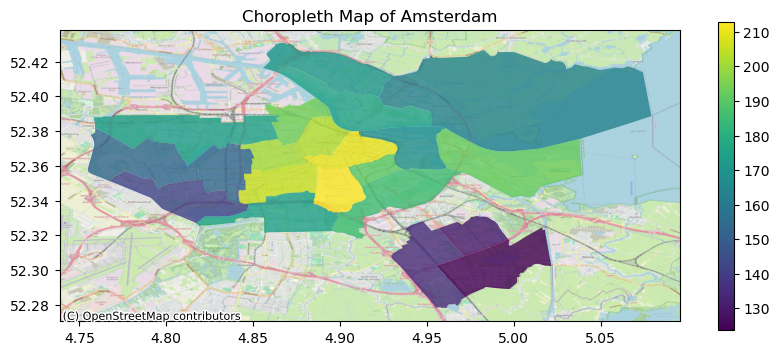

In [12]:
#| label: fig-price-choro
#| fig-cap: Listings by Price (choro)

import contextily as ctx

# Visualize the data
ax = gdf_neigh.plot(column='price', alpha=0.8, legend=True,  figsize=(10, 4))

ctx.add_basemap(ax, crs=gdf_neigh.crs.to_string(),  zoom=13, source=ctx.providers.OpenStreetMap.Mapnik)

plt.title('Choropleth Map of Amsterdam, by Price')
plt.xlabel('')
plt.ylabel('')
plt.show()


This approach allows for a clearer depiction of spatial disparities in pricing, enabling us to identify neighborhoods with higher or lower average prices. @fig-price-choro shows that highest prices are concentrated in central areas, particularly those near Amsterdam Central, reflecting the premium associated with proximity to major attractions and amenities. Conversely, lower prices tend to be observed in the south-eastern regions of Amsterdam, suggesting more affordable accommodations in these areas. Meanwhile, moderate prices are prevalent in the north-eastern neighborhoods, indicating a balance between accessibility and affordability.

## Reviews

In [16]:
#| code-fold: false
import pandas as pd

df_mean_r = pd.DataFrame(gdf.groupby('neighbourhood')['number_of_reviews'].agg('mean')).reset_index()
gdf_neigh_r = pd.merge(amsterdam_gdf, df_mean_r, on='neighbourhood', how='inner')

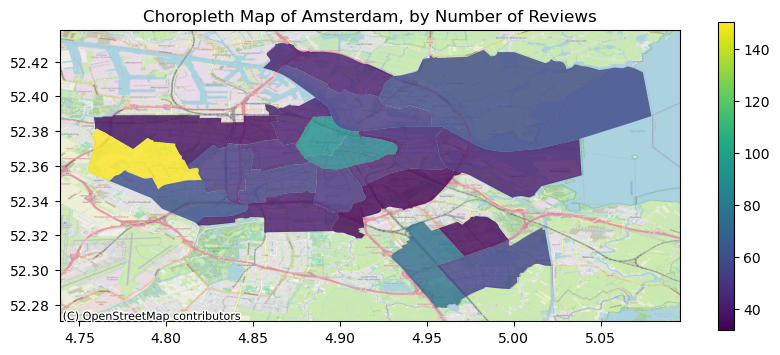

In [15]:
#| label: fig-reviews
#| fig-cap: Listings by Avg. Number of Reviews

import contextily as ctx

# Visualize the data
ax = gdf_neigh_r.plot(column='number_of_reviews', alpha=0.8, legend=True,  figsize=(10, 4))

ctx.add_basemap(ax, crs=gdf_neigh_r.crs.to_string(),  zoom=13, source=ctx.providers.OpenStreetMap.Mapnik)

plt.title('Choropleth Map of Amsterdam, by Avg. Number of Reviews')
plt.xlabel('')
plt.ylabel('')
plt.show()

In our analysis focusing on the average number of reviews by neighborhood, we see in @fig-reviews that Lutkemeer emerged as the neighborhood with the highest average number of reviews, indicating a notable level of guest activity and engagement within this area. Following closely, central neighborhoods also demonstrated a significant presence in terms of average number of reviews, reaffirming their popularity and desirability among guests visiting Amsterdam.